### Loss Functions

**studying CamDavidsonPilon sligthly adjusted plotting and code**

Statisticians and decision theorists defined loss functions. A loss function is a function of the true parameter, and an estimate of that parameter

$$ L( \theta, \hat{\theta} ) = f( \theta, \hat{\theta} )$$

Ex. loss function is the **squared-error loss** used in Linear Regression but it very sensitive to outliers

$$ L( \theta, \hat{\theta} ) = ( \theta -  \hat{\theta} )^2$$

The loss function imposes that large errors are very bad. A more robust loss function that increases linearly with the difference is the **absolute-loss**

$$ L( \theta, \hat{\theta} ) = | \theta -  \hat{\theta} | $$

Other popular loss functions like **zero-one loss** often used in classification algorithms.

$$L( \theta, \hat{\theta} ) = \mathbb{1}_{ \hat{\theta} \neq \theta }$$

and the **log-loss**: 

$$L( \theta, \hat{\theta} ) = -\hat{\theta}\log( \theta ) - (1-\hat{ \theta})\log( 1 - \theta ), \; \; \hat{\theta} \in {0,1}, \; \theta \in [0,1]$$

By shifting our focus from trying to be incredibly precise about parameter estimation to focusing on the outcomes of our parameter estimation, we can customize our estimates to be optimized for our application.

In Bayesian inference, we have a mindset that the unknown parameters are really random variables with prior and posterior distributions. Concerning the posterior distribution, a value drawn from it is a possible realization of what the true parameter could be. Given that realization, we can compute a loss associated with an estimate. **As we have a whole distribution of what the unknown parameter could be (the posterior), we should be more interested in computing the expected loss given an estimate. This expected loss is a better estimate of the true loss than comparing the given loss from only a single sample from the posterior**

The value chosen, if from a Bayesian posterior, is a Bayesian point estimate.

Suppose $P(\theta | X)$ is the posterior distribution of $\theta$ after observing data $X$, then the following function is understandable as the expected loss of choosing estimate $\hat{\theta}$ to estimate $\theta$:

$$ l(\hat{\theta} ) = E_{\theta}\left[ \; L(\theta, \hat{\theta}) \; \right] $$
This is also known as the risk of estimate $\hat{\theta}$. The subscript $\theta$ under the expectation symbol is used to denote that $\theta$ is the unknown (random) variable in the expectation, something that at first can be difficult to consider.

We spent all of last chapter discussing how to approximate expected values. Given $N$ samples $\theta_i,\; i=1,...,N$ from the posterior distribution, and a loss function $L$, we can approximate the expected loss of using estimate $\hat{\theta}$ by the Law of Large Numbers:

$$\frac{1}{N} \sum_{i=1}^N \;L(\theta_i, \hat{\theta} ) \approx E_{\theta}\left[ \; L(\theta, \hat{\theta}) \; \right]  = l(\hat{\theta} ) $$

The frequentist methods only aim to minimize error, not considering the loss associated with the result of that error. Aslo Frequentist methods are almost guaranteed to never be absolutely accurate. Bayesian point estimates fix this by planning ahead: **your estimate is going to be wrong, you might as well err on the right side of wrong**.

### Case: 'Showcase The Price is Right'

- 2 contestants compete 
- Each contestant is shown a unique suite of prizes.
- After the viewing, the contestants bid on the price for their unique suite of prizes.
 - If a bid price > actual price, the bid's owner is disqualified from winning.
 - If a bid price < true price by less than $250, the winner is awarded both prizes.
 
Suppose we have recorded the Showcases from previous The Price is Right episodes and have prior beliefs about what distribution the true price follows. For simplicity, suppose it follows a Normal:

$$\text{True Price} \sim \text{Normal}(\mu_p, \sigma_p )$$

Assume 
$$\mu_p = 35 000 \  \sigma_p = 7500$$

We need a model of how we should be playing the Showcase. For each prize in the prize suite, we have an idea of what it might cost, but this guess could differ significantly from the true price. Suppose beliefs about the prices of prizes also follow Normal distributions:

$$ \text{Prize}_i \sim \text{Normal}(\mu_i, \sigma_i ),\;\; i=1,2$$

**This is really why Bayesian analysis is great: we can specify what we think a fair price is through the $\mu_i$ parameter, and express uncertainty of our guess in the $\sigma_i$ parameter**

Assume two prizes per suite. True price of the prize suite is then given by ($\epsilon$ is some error term): 

$$\text{Prize}_1 + \text{Prize}_2 + \epsilon$$


**We are interested in the updated $\text{True Price}$ given we have observed both prizes and have belief distributions about them** First 2 prices are: 1) A trip to wonderful Toronto, Canada! and 2) A lovely new snowblower! 

$$\begin{align}
\text{snowblower} \sim \text{Normal}(3 000, 500 )\\\\
\text{Toronto} \sim \text{Normal}(12 000, 3000 )\\\\
\end{align}$$

In [30]:
%matplotlib inline
import scipy.stats as stats
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, 'helper_functions/')
from utilities import remove_borders

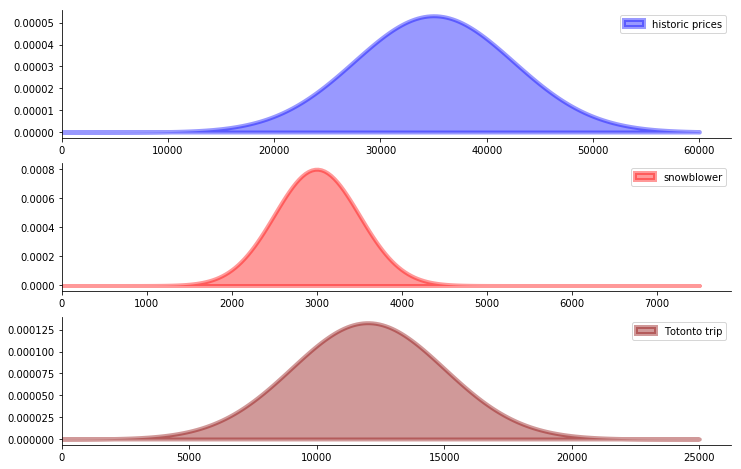

In [25]:
fig, ax = plt.subplots(3, 1 ,figsize=[12,8])

x = np.linspace(0,60000, 200)
ax[0].fill_between(x, y1=0,y2=stats.norm.pdf(x, 35000, 7500), color='blue', 
               alpha=.4, lw =4, label = 'historic prices')
x = np.linspace(0,7500, 200)
ax[1].fill_between(x, y1=0, y2=stats.norm.pdf(x, 3000, 500), color='red', 
               alpha=.4, lw =4, label = 'snowblower')
x = np.linspace(0,25000, 200)
ax[2].fill_between(x, y1=0,y2=stats.norm.pdf(x, 12000, 3000), color='darkred', 
               alpha=.4, lw =4, label = 'Totonto trip')
for i, x in enumerate(ax.flatten()):
    remove_borders(ax[i])
    ax[i].set(xlim = (0, None))
    ax[i].legend(loc='best')

In [31]:
# input 
prize_1_mu = 3000. # snowblower
prize_1_std = 500. # snowblower
prize_2_mu = 12000. # Toronto trip
prize_2_std = 3000. # Toronto trip

mu_prior = 35000.
std_prior =  7500.

with pm.Model() as model:
    
    true_price = pm.Normal("true_price", mu=mu_prior, sd=std_prior)
    
    prize_1 = pm.Normal("first_prize", mu=prize_1_mu, sd=prize_1_std)
    prize_2 = pm.Normal("second_prize", mu=prize_2_mu, sd=prize_2_std)
    price_estimate = prize_1 + prize_2
    
    logp = pm.Normal.dist(mu=price_estimate, sd=(3e3)).logp(true_price)
    error = pm.Potential("error", logp)
    

    trace = pm.sample(50000, step=pm.Metropolis())
    burned_trace = trace[10000:]

price_trace = burned_trace["true_price"]

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [second_prize]
>Metropolis: [first_prize]
>Metropolis: [true_price]
Sampling 2 chains: 100%|██████████| 101000/101000 [00:32<00:00, 3100.60draws/s]
/home/diederik/anaconda3/lib/python3.6/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)
The number of effective samples is smaller than 10% for some parameters.


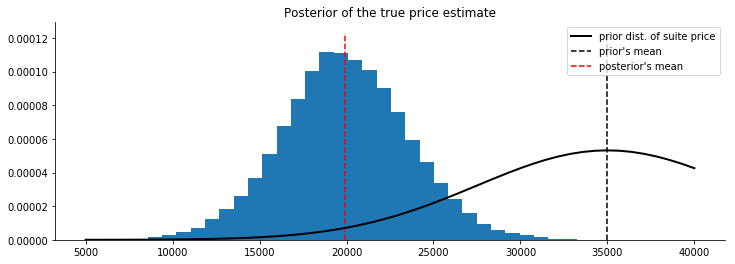

In [40]:
fig, ax = plt.subplots(figsize=[12,4])

x = np.linspace(5000, 40000)
ax.plot(x, stats.norm.pdf(x, 35000, 7500), c = "k", lw = 2, 
        label = "prior dist. of suite price")

_hist = ax.hist(price_trace, bins = 35, density= True, histtype= "stepfilled")
ax.set(title = "Posterior of the true price estimate")
ax.vlines(mu_prior, 0, 1.1 * np.max(_hist[0]), label = "prior's mean",
          linestyles="--")
ax.vlines(price_trace.mean(), 0, 1.1 * np.max(_hist[0]), \
          label = "posterior's mean", linestyles="--", color='red')
_ = ax.legend(loc='best')
remove_borders(ax)

Our 2 observed prize guesses shifted our mean price estimate down about \$15,000 dollars from the previous mean price.

A frequentist, seeing the two prizes and having the same beliefs about their prices, would bid $\mu_1 + \mu_2 = 35000$, regardless of any uncertainty. Meanwhile, the naive Bayesian would simply pick the mean of the posterior distribution. **we have more information about our eventual outcomes; we should incorporate this into our bid**. We will use the loss function above to find the best bid (best according to our loss).

What might a contestant's loss function look like? I would think it would look something like:

```def showcase_loss(guess, true_price, risk = 80000):
    if true_price < guess:
        return risk
    elif abs(true_price - guess) <= 250:
        return -2*np.abs(true_price)
    else:
        return np.abs(true_price - guess - 250)```

where risk is a parameter that defines of how bad it is if your guess is over the true price. A lower risk means that you are more comfortable with the idea of going over. If we do bid under and the difference is less than $250, we receive both prizes (modeled here as receiving twice the original prize). Otherwise, when we bid under the true_price we want to be as close as possible, hence the else loss is a increasing function of the distance between the guess and true price.

For every possible bid, we calculate the expected loss associated with that bid. We vary the risk parameter to see how it affects our loss:

/home/diederik/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  


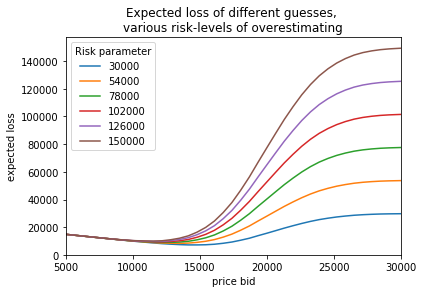

In [41]:
def showdown_loss(guess, true_price, risk = 80000):
        loss = np.zeros_like(true_price)
        ix = true_price < guess
        loss[~ix] = np.abs(guess - true_price[~ix])
        close_mask = [abs(true_price - guess) <= 250]
        loss[close_mask] = -2*true_price[close_mask]
        loss[ix] = risk
        return loss


guesses = np.linspace(5000, 50000, 70) 
risks = np.linspace(30000, 150000, 6)
expected_loss = lambda guess, risk: \
    showdown_loss(guess, price_trace, risk).mean()
        
for _p in risks:
    results = [expected_loss(_g, _p) for _g in guesses]
    plt.plot(guesses, results, label = "%d"%_p)
    
plt.title("Expected loss of different guesses, \nvarious risk-levels of \
overestimating")
plt.legend(loc="upper left", title="Risk parameter")
plt.xlabel("price bid")
plt.ylabel("expected loss")
plt.xlim(5000, 30000);